In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


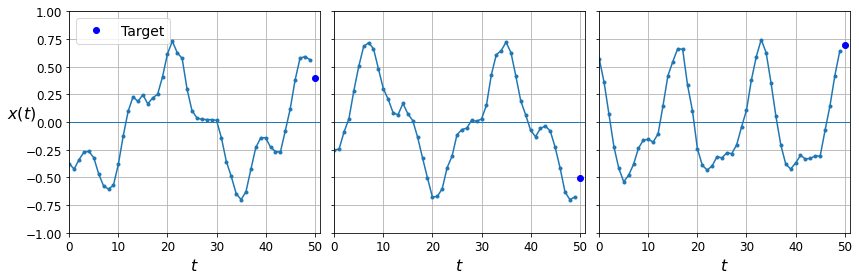

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

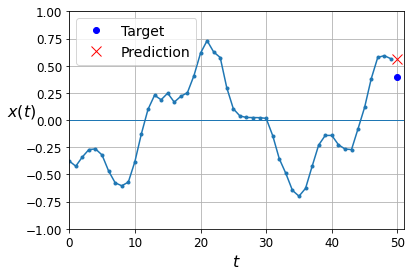

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 872us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 566us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 611us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 585us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 557us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 585us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 585us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 588us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 588us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 521us/step - loss: 0.006

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 355us/step - loss: 0.0042


0.004168086685240269

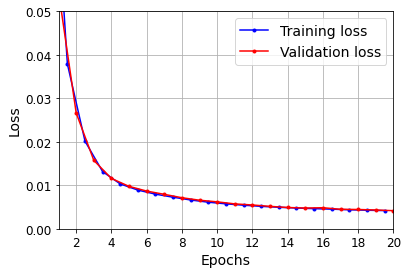

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

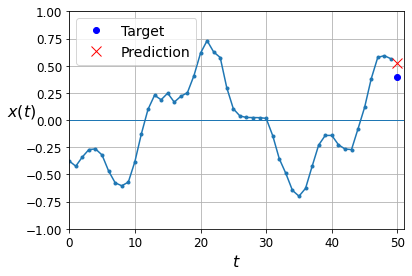

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

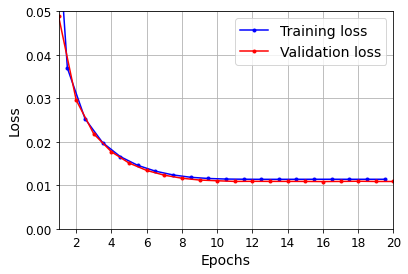

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

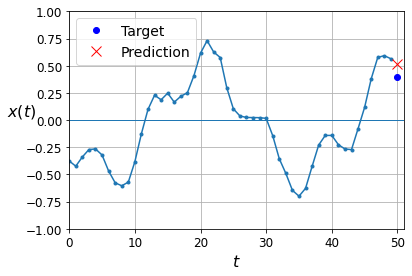

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0031

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0029


0.002910565584897995

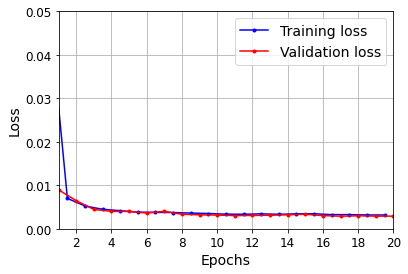

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

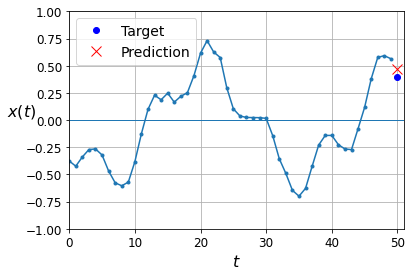

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0026


0.0026236234698444605

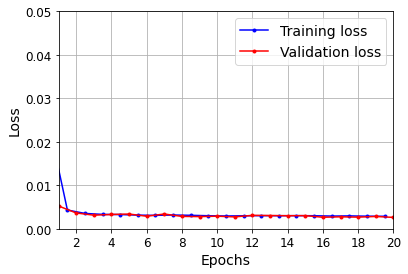

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

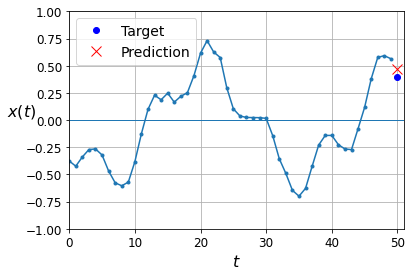

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [24]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [25]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


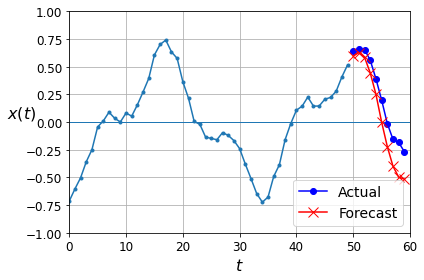

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [27]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [29]:
Y_pred.shape

(2000, 10)

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510868

In [31]:
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 721us/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 536us/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 533us/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 531us/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 537us/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 542us/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 545us/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 536us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 538us/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 534us/step - loss: 0.022

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 6ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0110 - val_loss: 0.0100

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

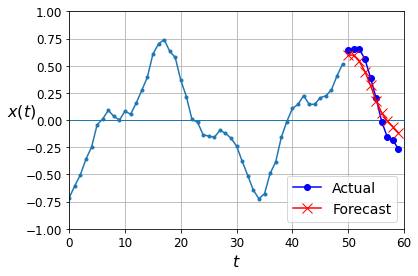

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [36]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0367 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0327 - last_time_step_mse: 0.0216 - val_loss: 0.0301 - val_last_time_step_mse: 0.0190
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0301 - last_time_step_mse: 0.0191 - val_loss: 0.0272 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0275 - last_time_step_mse: 0.0155 - val_loss: 0.0258 - val_last_time_step_mse: 0.0138
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0252 - last_time_step_mse: 0.0126 - val_loss: 0.0258 - val_last_time_step_mse: 0.0139
Epoch 7/20
219/219 [========

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

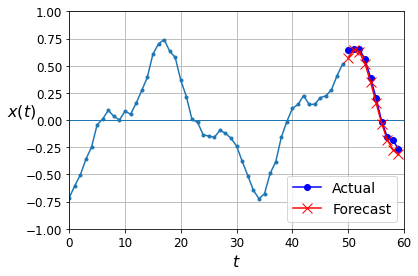

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [========

In [42]:
from tensorflow.keras.layers import LayerNormalization

In [43]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 16ms/step - loss: 0.1597 - last_time_step_mse: 0.1549 - val_loss: 0.0749 - val_last_time_step_mse: 0.0692
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0666 - last_time_step_mse: 0.0579 - val_loss: 0.0601 - val_last_time_step_mse: 0.0492
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0565 - last_time_step_mse: 0.0457 - val_loss: 0.0529 - val_last_time_step_mse: 0.0408
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0501 - last_time_step_mse: 0.0379 - val_loss: 0.0465 - val_last_time_step_mse: 0.0332
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0444 - last_time_step_mse: 0.0308 - val_loss: 0.0423 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0399 - last_time_step_mse: 0.0266 - val_loss: 0.0373 - val_last_time_step_mse: 0.0234
Epoch 7/20
219/219 [==

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 16ms/step - loss: 0.1597 - last_time_step_mse: 0.1549 - val_loss: 0.0749 - val_last_time_step_mse: 0.0692
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0666 - last_time_step_mse: 0.0579 - val_loss: 0.0601 - val_last_time_step_mse: 0.0492
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0565 - last_time_step_mse: 0.0457 - val_loss: 0.0529 - val_last_time_step_mse: 0.0408
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0501 - last_time_step_mse: 0.0379 - val_loss: 0.0465 - val_last_time_step_mse: 0.0332
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0444 - last_time_step_mse: 0.0308 - val_loss: 0.0423 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0399 - last_time_step_mse: 0.0266 - val_loss: 0.0373 - val_last_time_step_mse: 0.0234
Epoch 7/20
219/219 [==

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 13ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 3s 11ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [48]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788683116436005, 0.008560801856219769]

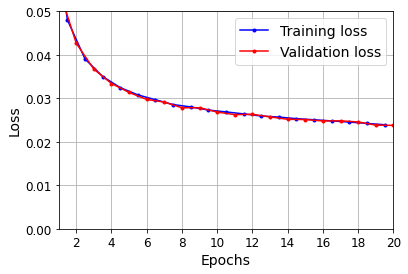

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

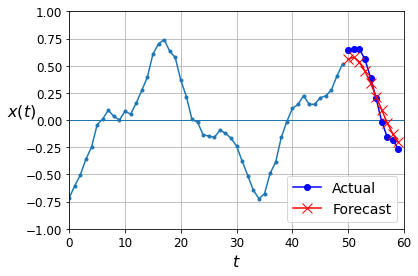

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [53]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785503581166267, 0.01026280876249075]

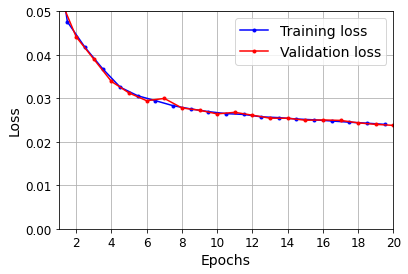

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

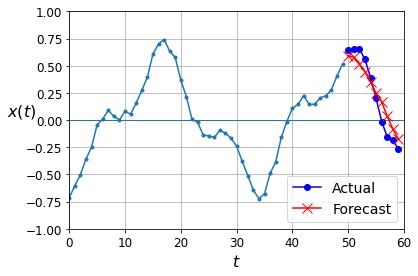

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 4s 9ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0669 - last_time_step_mse: 0.0543 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0324 - last_time_step_mse: 0.0193 - val_loss: 0.0295 - val_last_time_step_mse: 0.0168
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0283 - last_time_step_mse: 0.0156 - val_loss: 0.0270 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0261 - last_time_step_mse: 0.0136 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0248 - last_time_step_mse: 0.0124 - val_loss: 0.0244 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0240 - last_time_step_mse: 0.0117 - val_loss: 0.0233 - val_last_time_step_mse: 0.0107
Epoch 7/20
219/219 [========

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 2s 6ms/step - loss: 0.1300 - last_time_step_mse: 0.1260 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 1s 5ms/step - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In [63]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

In [64]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [65]:
train_files

['C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [66]:
eval_files

['C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\Swalllow1219\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [67]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [68]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [69]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [70]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [71]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [72]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [73]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.08627451  0.11764706  0.        ]
  [-0.01176471  0.16806725  0.        ]
  [ 0.02352941  0.07563025  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.04705882 -0.06696428  0.        ]
  [-0.09019607 -0.07142857  0.        ]
  [-0.0862745  -0.04464286  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [ 0.00784314  0.11320752  0.        ]
  ...
  [ 0.11764708  0.01886791  0.        ]
  [-0.03529412  0.12264156  0.        ]
  [-0.19215688  0.33962262  1.        ]]

 ...

 [[-0.21276593 -0.01960784  0.        ]
  [-0.31382978  0.00784314  0.        ]
  [-0.37234044  0.13725491  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

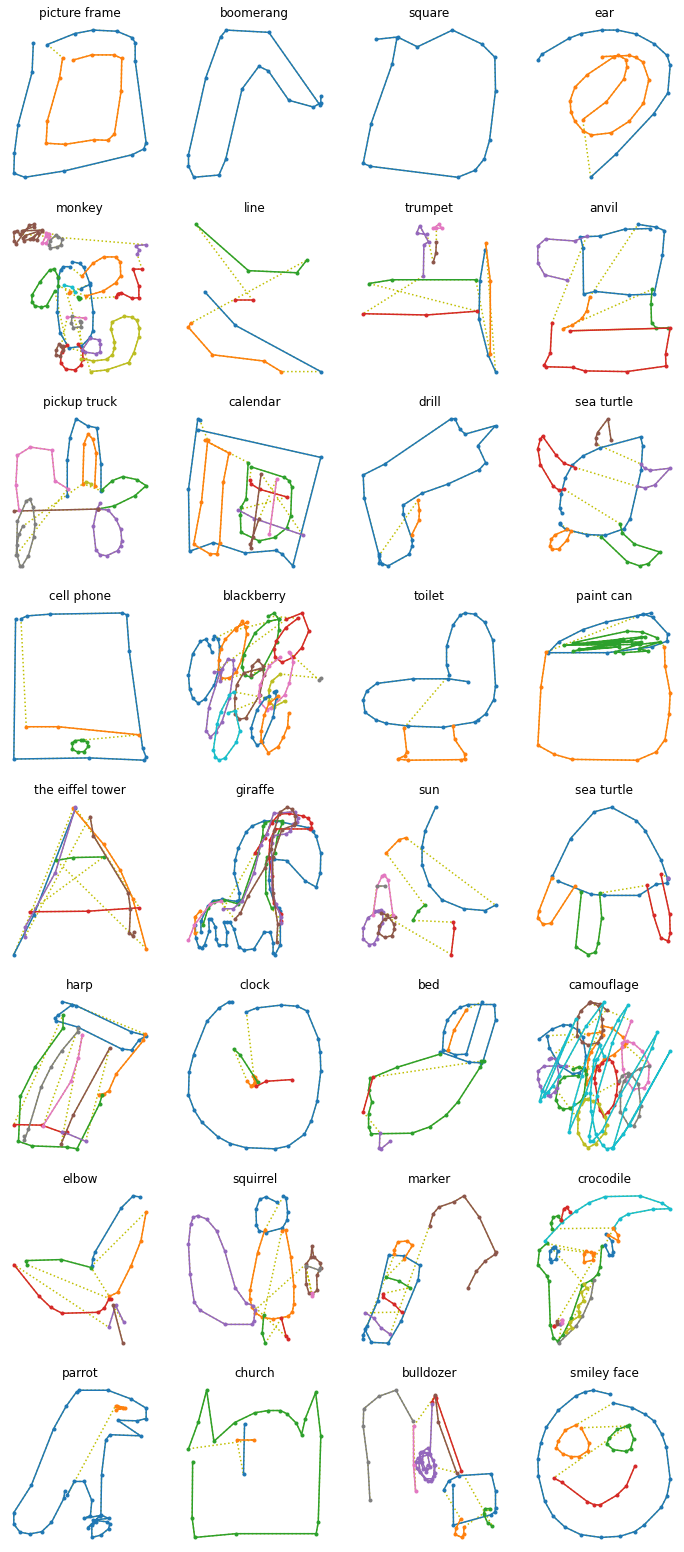

In [74]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

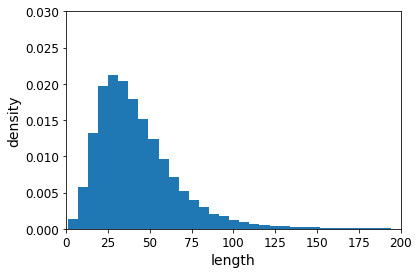

In [75]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [76]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [77]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 867s 8ms/step - loss: 4.0801 - accuracy: 0.1709 - sparse_top_k_categorical_accuracy: 0.3751 - val_loss: 3.0762 - val_accuracy: 0.3120 - val_sparse_top_k_categorical_accuracy: 0.5971
Epoch 2/2
107813/107813 [==============================] - 897s 8ms/step - loss: 2.7025 - accuracy: 0.3798 - sparse_top_k_categorical_accuracy: 0.6692 - val_loss: 2.4247 - val_accuracy: 0.4334 - val_sparse_top_k_categorical_accuracy: 0.7205


In [78]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [79]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6134019

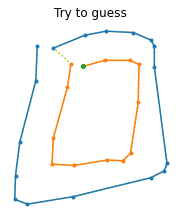

Top-5 predictions:
  1. oven 17.573%
  2. cell phone 16.861%
  3. television 6.658%
  4. picture frame 5.128%
  5. cooler 4.588%
Answer: picture frame


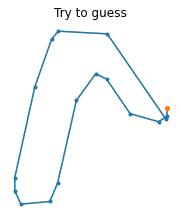

Top-5 predictions:
  1. moustache 15.813%
  2. trumpet 10.171%
  3. dolphin 7.550%
  4. rifle 6.381%
  5. bowtie 5.340%
Answer: boomerang


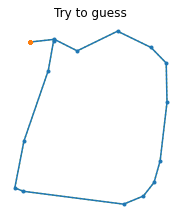

Top-5 predictions:
  1. hexagon 51.535%
  2. octagon 13.180%
  3. wine bottle 4.751%
  4. square 2.774%
  5. triangle 2.524%
Answer: square


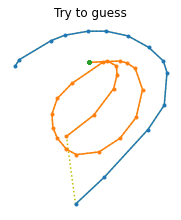

Top-5 predictions:
  1. ear 69.857%
  2. boomerang 7.072%
  3. moon 4.943%
  4. light bulb 3.299%
  5. paper clip 2.788%
Answer: ear


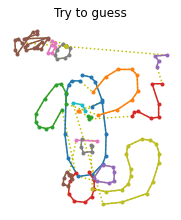

Top-5 predictions:
  1. mermaid 29.755%
  2. monkey 14.252%
  3. teddy-bear 12.800%
  4. angel 4.851%
  5. lobster 3.835%
Answer: monkey


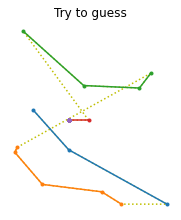

Top-5 predictions:
  1. rain 10.910%
  2. chair 8.597%
  3. fork 8.180%
  4. diving board 4.486%
  5. ceiling fan 4.226%
Answer: line


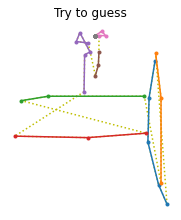

Top-5 predictions:
  1. see saw 10.734%
  2. yoga 10.516%
  3. snowflake 6.238%
  4. candle 6.048%
  5. palm tree 3.368%
Answer: trumpet


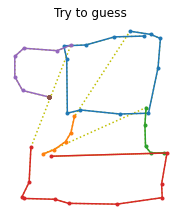

Top-5 predictions:
  1. yoga 34.580%
  2. shovel 11.344%
  3. syringe 8.607%
  4. screwdriver 7.456%
  5. floor lamp 3.978%
Answer: anvil


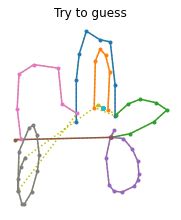

Top-5 predictions:
  1. bicycle 24.248%
  2. motorbike 24.161%
  3. tractor 14.697%
  4. eyeglasses 7.424%
  5. pickup truck 4.786%
Answer: pickup truck


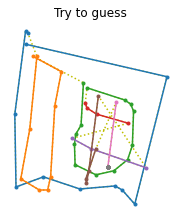

Top-5 predictions:
  1. power outlet 30.785%
  2. ant 6.701%
  3. hospital 4.383%
  4. stereo 4.318%
  5. table 3.658%
Answer: calendar


In [80]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [81]:
model.save("my_sketchrnn")

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets
